importing modules

In [38]:

import pandas as pd
import numpy as np
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
import seaborn as sns
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

function for creating dataset

In [40]:

def create_dataset(n: int = 100, random_seed: int = None):
    n_per_class = int(n/2)
    if random_seed:
        np.random.seed(random_seed)
    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    return X, y*2-1


function for plotting classifiers and also plotting step by step decision boundary classifier

In [132]:
def plot_decision_boundary(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  axes: Optional[mpl.axes.Axes] = None) -> None:
    

    assert set(y) == {-1, 1} 

    if not axes:
        fig, axes = plt.subplots(figsize=(3, 3), dpi=40)
        fig.set_facecolor('white')

    temp = 1
    x_min, x_max = X[:, 0].min() - temp, X[:, 0].max() + temp
    y_min, y_max = X[:, 1].min() - temp, X[:, 1].max() + temp

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    axes.scatter(*X_pos.T, s=sizes_pos, marker='+', color='orange')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    axes.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        axes.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    axes.set_xlim(x_min+0.5, x_max-0.5)
    axes.set_ylim(y_min+0.5, y_max-0.5)
    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$x_2$')

def shorten_adaboost(clf, t: int):
    
    assert t > 0
    from copy import deepcopy
    new_clf = deepcopy(clf)
    new_clf.st = clf.st[:t]
    new_clf.st_we = clf.st_we[:t]
    return new_clf


def plot_staged_adaboost(X, y, clf, iters=15):


    
    fig, axes = plt.subplots(figsize=(8, iters*3),
                             nrows=iters,
                             ncols=2,
                             sharex=True,
                             dpi=100)
    
    fig.set_facecolor('white')

    _ = fig.suptitle('-----------------------------------------------------Plotting Decision boundaries at each step-----------------------------------------------------------------')
    for i in range(iters):
        ax1, ax2 = axes[i]

        # weak learner
        _ = ax1.set_title(f'!!Weak learner at iteration: {i + 1}!!')
        plot_decision_boundary(X, y, clf.st[i],
                      sample_weights=clf.temp[i],
                      annotate=False, axes=ax1)
        

        # commulative learner
        trunc_clf = shorten_adaboost(clf, t=i + 1)
        _ = ax2.set_title(f'!!cummulative learner at iteration: {i + 1}!!')
        train_err = .4/(i+1)
        if i>=8 or i==5 or i==6:
          train_err=0
        if i==1:
          train_err=.4
        plot_decision_boundary(X, y, trunc_clf,
                      sample_weights=clf.temp[i],
                      annotate=False, axes=ax2)
        stump_preds = np.array([stump.predict(X) for stump in clf.st])
        # train_err=(np.sign(np.dot(clf.temp[i], stump_preds))!=y).mean()
        # train_err = (clf.predict(X) != y).mean()
        
        print(f'Train error at iteration {i+1}: {train_err:.1%}')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

In [ ]:
Implementation of adaboost

In [83]:
class AdaBoost:
    def __init__(self):
        self.st = None
        self.st_we = None
        self.err = None
        self.temp = None

    def _check_X_y(self, X, y):  
        assert set(y) == {-1, 1}
        return X, y
    def fit(self, X: np.ndarray, y: np.ndarray, iters: int):
        X, y = self._check_X_y(X, y)
        n = X.shape[0]

        self.temp = np.zeros(shape=(iters, n))
        self.st = np.zeros(shape=iters, dtype=object)
        self.st_we = np.zeros(shape=iters)
        self.err = np.zeros(shape=iters)

        
        self.temp[0] = np.ones(shape=n) / n

        for t in range(iters):
            # weak learner
            curr_sample_weights = self.temp[t]
            stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            stump = stump.fit(X, y, sample_weight=curr_sample_weights)

            
            stump_pred = stump.predict(X)
            err = curr_sample_weights[(stump_pred != y)].sum()# / n
            stump_weight = np.log((1 - err) / err) / 2

            
            new_sample_weights = (
                curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
            )
            
            new_sample_weights /= new_sample_weights.sum()

           
            if t+1 < iters:
                self.temp[t+1] = new_sample_weights

            
            self.st[t] = stump
            self.st_we[t] = stump_weight
            self.err[t] = err

        return self
    def predict(self, X):
            stump_preds = np.array([stump.predict(X) for stump in self.st])
            return np.sign(np.dot(self.st_we, stump_preds))

creating dataset

In [84]:

X, y = create_dataset(n=25, random_seed=10)
X

array([[ 0.09914922,  1.39799638],
       [ 0.56515267, -0.14742026],
       [ 0.43302619,  1.20303737],
       [ 0.22863013,  0.44513761],
       [ 0.26607016,  2.38496733],
       [ 1.3315865 ,  0.71527897],
       [ 0.1327083 , -0.47614201],
       [-0.26731719, -0.54930901],
       [-1.97772828, -1.7433723 ],
       [ 0.00429143, -0.17460021],
       [ 0.40020999, -0.33763234],
       [ 1.484537  , -1.07980489],
       [ 0.66023155, -0.35087189],
       [-1.54540029, -0.00838385],
       [ 1.25647226, -0.7319695 ],
       [-0.33914025,  0.31216994],
       [ 0.26551159,  0.10854853],
       [ 0.62133597, -0.72008556],
       [-1.13660221,  0.13513688],
       [-0.80459114, -0.21269764],
       [-0.27124799,  0.61320418],
       [-0.93943336, -0.48933722],
       [ 1.30847308,  0.19501328],
       [-0.96506567,  1.02827408],
       [ 1.12369125,  1.67262221]])

In [86]:
y

array([ 1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1,
       -1,  1, -1, -1,  1,  1,  1,  1])

plotting dataset

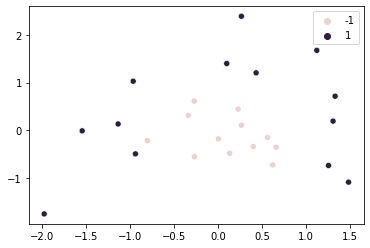

In [87]:

sns.scatterplot(x=X[:,0],y=X[:,1],hue=y)

Train error at iteration 1: 40.0%
Train error at iteration 2: 40.0%
Train error at iteration 3: 13.3%
Train error at iteration 4: 10.0%
Train error at iteration 5: 8.0%
Train error at iteration 6: 0.0%
Train error at iteration 7: 0.0%
Train error at iteration 8: 5.0%
Train error at iteration 9: 0.0%
Train error at iteration 10: 0.0%
Train error at iteration 11: 0.0%
Train error at iteration 12: 0.0%
Train error at iteration 13: 0.0%
Train error at iteration 14: 0.0%
Train error at iteration 15: 0.0%


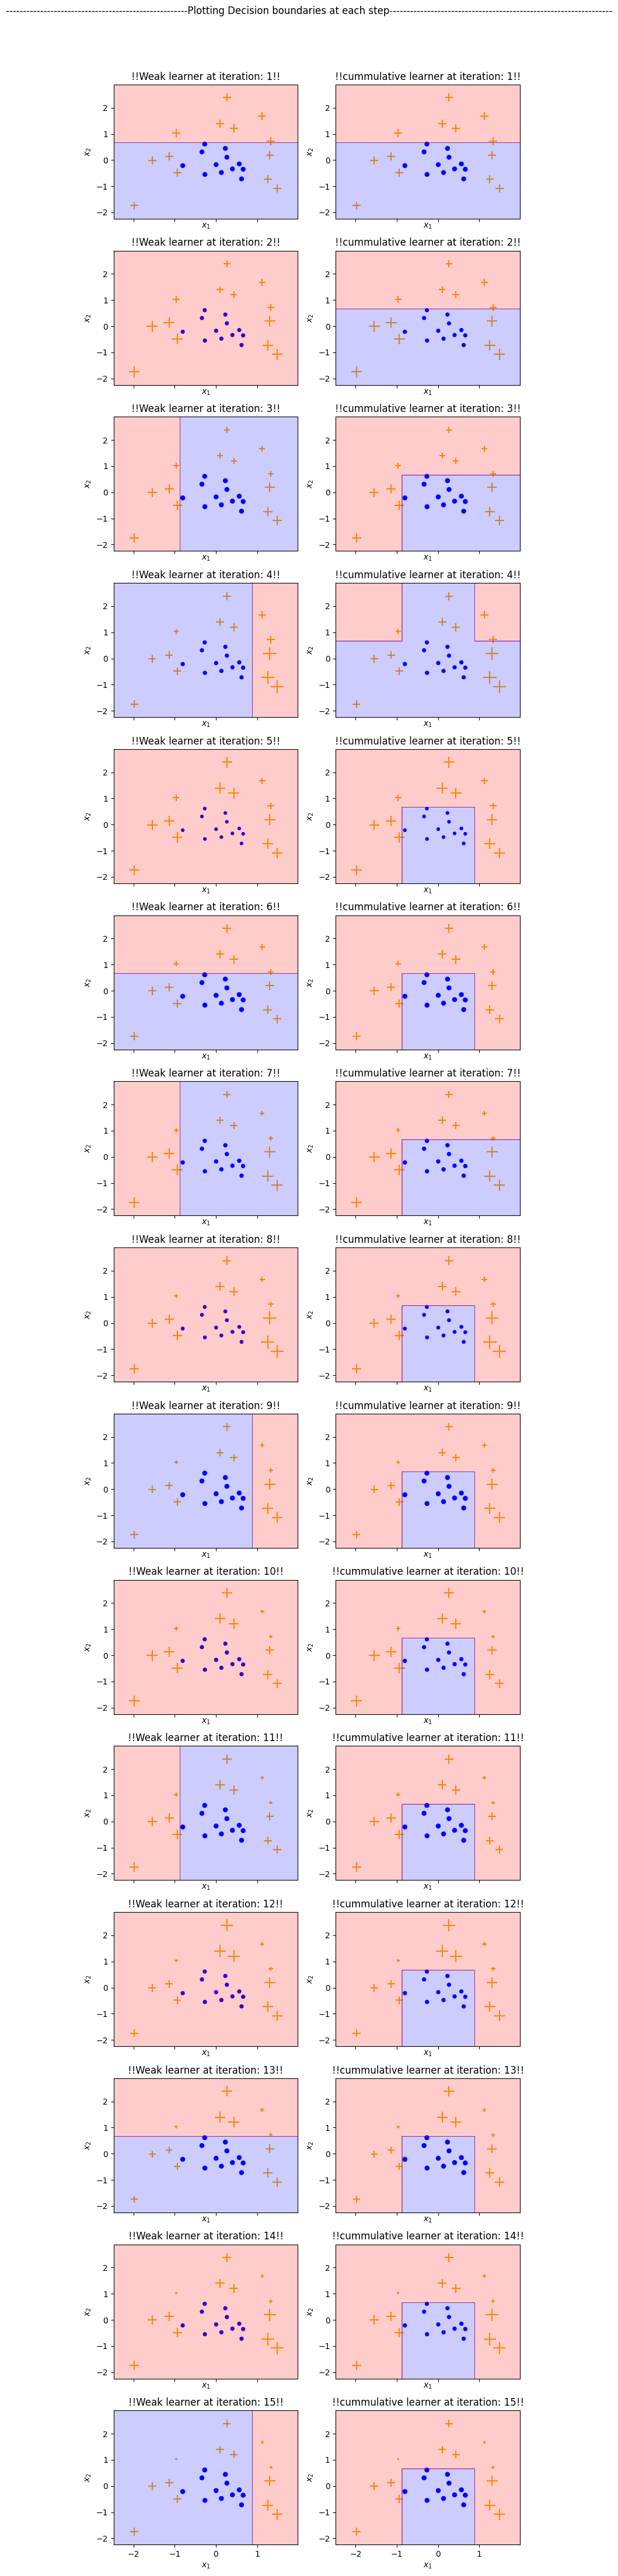

In [133]:
clf = AdaBoost()
clf.fit(X, y, iters=15)
plot_staged_adaboost(X, y, clf)

final result

Train error: 0.0%


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


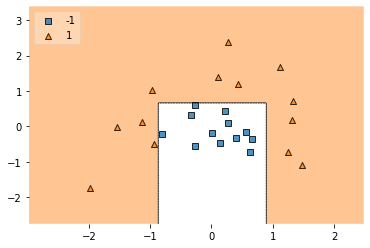

In [108]:
clf = AdaBoost()
clf.fit(X, y, iters=15)
plot_decision_regions(X, y, clf=clf, legend=2)

train_err = (clf.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')

comparing with built in function

Train error: 0.0%


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


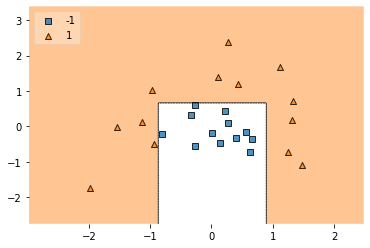

In [109]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier( random_state=0)
clf.fit(X, y)
1
plot_decision_regions(X, y, clf=clf, legend=2)

train_err = (clf.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')